# Model Free Footprints

Generate footprints from data without correction and from reads pileup.

In [7]:
import pyBigWig
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [68]:
config = pd.read_csv("../../configs/cluster.tsv", sep='\t')
config

,cluster,colour,description,new_cluster
0,1,#B03743,Fibroblast,1
1,2,#E85F6D,Fibroblast-like,3
2,3,#7C2730,Fibroblast-like,2
3,4,#F0A118,Intermediate,12
4,5,#78A824,Pre-iPSC,13
5,6,#A6D854,Pre-iPSC,14
6,7,#F01D35,Fibroblast-like,5
7,8,#13C4A3,iPSC,15
8,9,#406614,Partially-reprogrammed,10
9,10,#D4B81C,Intermediate,9


In [69]:
HEADER = ['chr', 'start', 'end', 'strand', 'score', 'seq']

In [70]:
MOTIFS = ['KLF', 'OCTSOX', 'AP1']

# copied from ../Aff_vs_conc_footprints output
BREAKS = {
    'KLF': [4.7, 6.7, 8.2, 10.0],
    'OCTSOX': [5.3, 7.5, 9.1, 13.5],
    'AP1': [6.9, 9.2, 10.1, 11.5]
}

CLUSTS = [11,14,4,5,6,8,1]

In [118]:
clust_hits = defaultdict(lambda: defaultdict(dict))
MAX_HITS_PER_BIN = 10000 # hits are already shuffled so can just pick from top

for m in MOTIFS:
    for i in CLUSTS:
        cur_hits = pd.read_csv("./model_free_footprints/scans/{}.c{}.bed".format(m, i), sep='\t', names=HEADER)
        
        for j in range(len(BREAKS[m])-1):
            clust_hits[m][i][BREAKS[m][j]] = cur_hits[(cur_hits['score'] > BREAKS[m][j])&(cur_hits['score'] < BREAKS[m][j+1])]
            
            clust_hits[m][i][BREAKS[m][j]] = clust_hits[m][i][BREAKS[m][j]][:MAX_HITS_PER_BIN]        

In [119]:
def get_vals(bw_file, regs, w=1000):
    vals = []
    bw = pyBigWig.open(bw_file)
    
    motif_half_len = (regs.iloc[0]['end'] - regs.iloc[0]['start'])//2
    
    for _, x in tqdm(regs.iterrows(), total=regs.shape[0]):
        if x['strand'] == "+":
            vals.append(np.nan_to_num(bw.values(x['chr'], x['start']+motif_half_len-w//2, x['start']+motif_half_len+w//2)))
        else:
            vals.append(np.nan_to_num(bw.values(x['chr'], x['end']-motif_half_len-w//2, x['end']-motif_half_len+w//2))[::-1])
    
    bw.close()
    
    return np.array(vals)

In [120]:
clust_insertions = defaultdict(lambda: defaultdict(dict))

for m in MOTIFS:
    for i in CLUSTS:
        for j in range(len(BREAKS[m])-1):
            clust_insertions[m][i][BREAKS[m][j]] = get_vals("/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx{}.bw".format(i),
                                                          clust_hits[m][i][BREAKS[m][j]],
                                                            w=2000)

100%|██████████| 10000/10000 [00:04<00:00, 2284.64it/s]


In [121]:
def plot_footprints_grid(insertions, hits, aff_breaks, width=100, rev_y = False, cell_states=None):
    # aff_breaks -> [min, break1, break2, max]
    
    if cell_states is None:
        cell_states = list(insertions.keys())
        
    affs = list(insertions[cell_states[0]].keys())
    
    fig, axs = plt.subplots(len(aff_breaks)-1, len(cell_states), figsize=(3*len(cell_states),4*len(affs)), sharey=True)
    
    start = insertions[cell_states[0]][affs[0]].shape[1]//2-width//2
    end = insertions[cell_states[0]][affs[0]].shape[1]//2+width//2
    
    for cidx,cs in enumerate(cell_states):
        for aidx,aff in enumerate(affs):
            y_idx = aidx if not rev_y else len(affs)-aidx-1

            # subset to range of affinity
            cur_insertions = insertions[cs][aff]
            # row normalize
            cur_insertions = cur_insertions/np.sum(cur_insertions, axis=1, keepdims=True)
            cur_insertions = cur_insertions.mean(0)
                                                        
            axs[y_idx][cidx].plot(range(-width//2,width//2), cur_insertions[start:end], 
                           c='k')
#                            c= config.iloc[cs-1]['colour'])

    for ax, col in zip(axs[0], cell_states):
        ax.set_title("{} - {}".format(config.iloc[col-1]["new_cluster"], 
                                      config.iloc[col-1]["description"]), 
                     size=16)

    for i in range(len(aff_breaks)-1):
        for j in range(len(cell_states)):
            axs[i][j].set_xticklabels([])

    y_labels = ["{:.1f} - {:.1f}".format(aff_breaks[i], aff_breaks[i+1]) for i in range(len(aff_breaks)-1)]
    if rev_y:
        y_labels = y_labels[::-1]
    for ax, row in zip(axs[:, 0], y_labels):
        ax.set_ylabel(row, size=16)

    fig.suptitle('Cell State', size=20)
    fig.text(0.05, 0.5, 'Motif Affinity Bin', va='center', rotation='vertical', size=20)

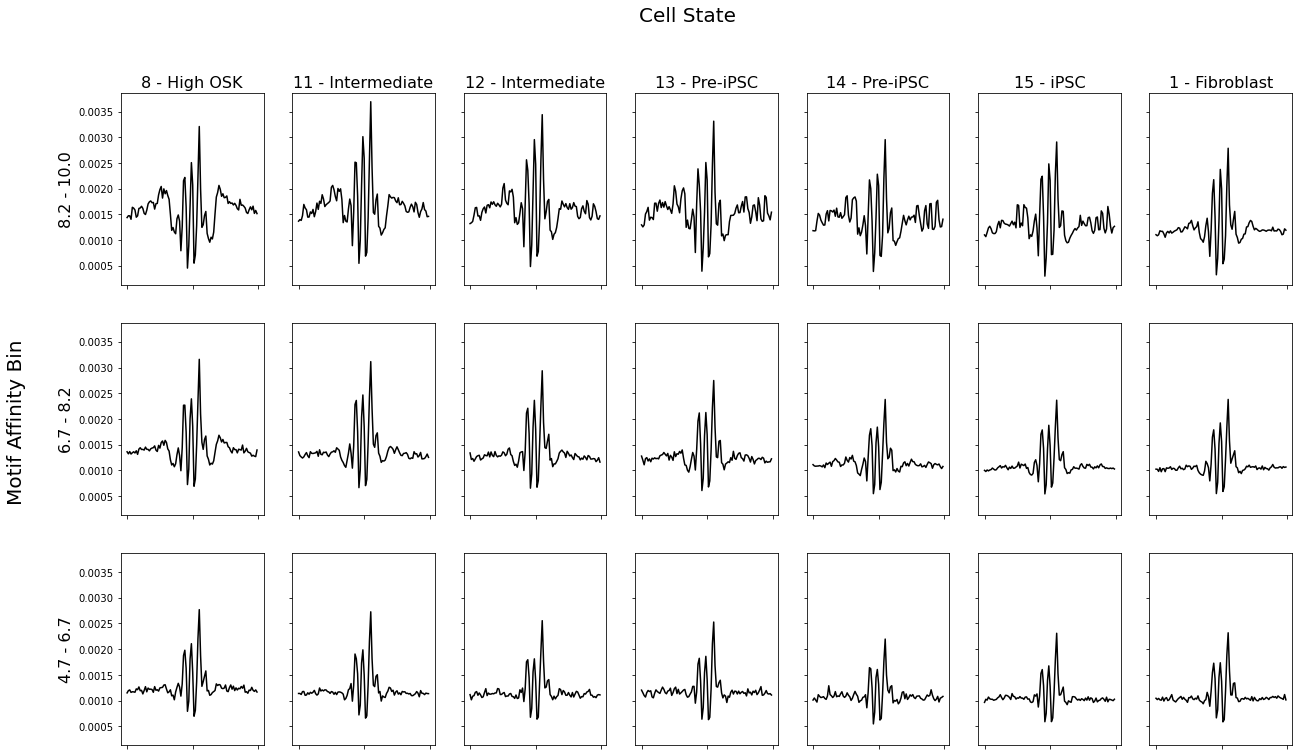

In [125]:
plot_footprints_grid(clust_insertions["KLF"], clust_hits["KLF"], BREAKS["KLF"], width=100, rev_y=True)
plt.savefig("../subfigs/footprinting/aggregation/KLF.q3.pdf")

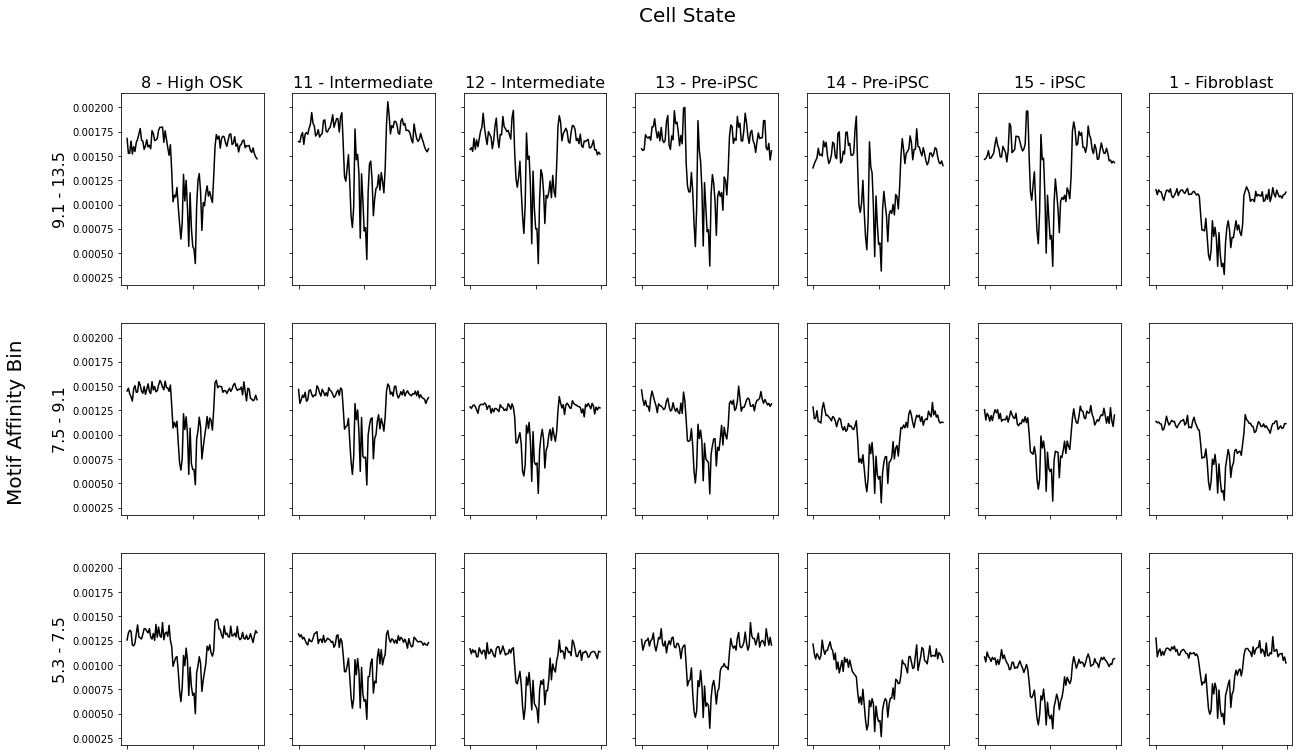

In [126]:
plot_footprints_grid(clust_insertions["OCTSOX"], clust_hits["OCTSOX"], BREAKS["OCTSOX"], width=100, rev_y=True)
plt.savefig("../subfigs/footprinting/aggregation/OCTSOX.q3.pdf")

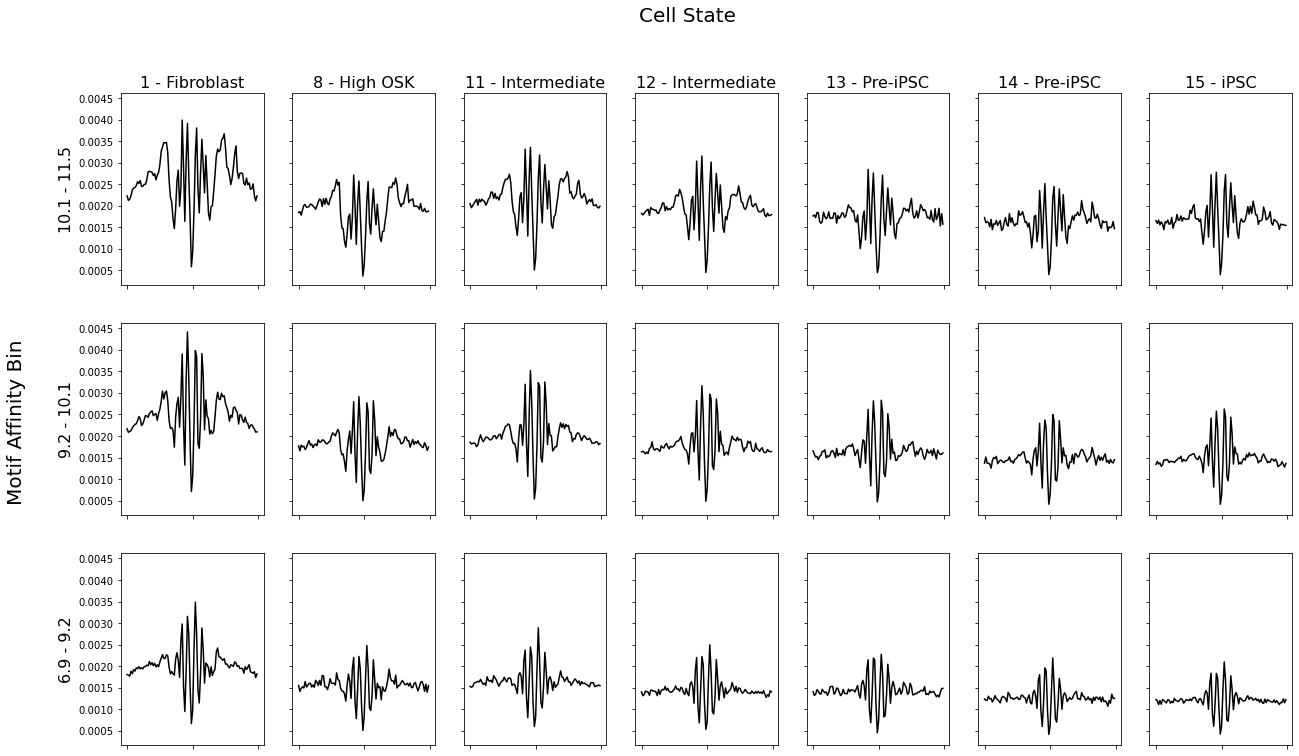

In [127]:
plot_footprints_grid(clust_insertions["AP1"], clust_hits["AP1"], BREAKS["AP1"], width=100, rev_y=True, cell_states=[1] + CLUSTS[:-1])
plt.savefig("../subfigs/footprinting/aggregation/AP1.q3.pdf")